### Spoofing Case Grouping & Analysis

In [32]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy
import re
import xlrd
from datetime import date
from xlsxwriter.utility import xl_rowcol_to_cell
from random import sample
from math import log10, floor
from src.data_models.smartshelper import metrics, fixNum, unSMART, cparty, littleQA, totalUP
from src.data_models.SmartsDataModel import SmartsDataModel
from src.data_models.SmartsCsvDataModel import SmartsCsvDataModel
from src.utility.DataModelUtility import execute_query_data_frame

def perc(arg,df): print(str(int(arg*100)) + 'th Percentile: ' + str(int(round(df.quantile(arg)))))

#### >>> Input Data

In [33]:
alerts0 = fixNum(unSMART(pd.read_excel('~/Documents/datafldr/smarts1_2019May.xlsx')))
# alerts0.groupby(['AlertCode','ShortText']).count()['Market']

-> type fixed, kept 554 rows, 49 columns


#### >>> Straightforward Alerts (4022, 4023, 4032-single event)

In [34]:
alerts4032_noneod = alerts0.loc[alerts0['ShortText'] == 'MULTI ORDER SPOOFING'].reset_index(drop=True)
alerts4022 = alerts0.loc[alerts0['AlertCode'] == 4022].drop(columns='AlertAttachment').reset_index(drop=True)
alerts4023 = alerts0.loc[alerts0['AlertCode'] == 4023].drop(columns='AlertAttachment').reset_index(drop=True)

In [37]:
alerts4032_noneod.loc[alerts4032_noneod['AccountIDCode'] == 411770]

,Market,StartDate,AlertSet,AlertSetName,StartTime,Date,Time,DisplayTime,InstrumentCode,InstrumentName,...,Intensity,TraderID,AccountIDID,AccountIDName,AlertCode,ReissueCount,UserActionCount,Documents,month,year
6,gemini,2019-05-10,Main,Main,14:19:08,2019-05-10,14:19:08,D+1|01:49:18,ETHUSD,ETHUSD,...,86,0,4962,411770,4032,0,0,0,5,2019


#### >>> Text File Alerts (4032-eod)

In [4]:
alerts4032_eod = alerts0.loc[alerts0['ShortText'] == 'MULTI ORDER SPOOFING EOD',['Date','InstrumentName','AccountIDName','AlertID']].reset_index(drop=True)
alerts4032_eod2 = pd.DataFrame(alerts4032_eod.groupby(['Date','InstrumentName','AccountIDName']).count().reset_index(drop=False))
alerts4032_eod2['Date2'] = '_' + alerts4032_eod2['Date'].astype(str).str.replace('-','') + '.csv'
alerts4032_eod2['ImportSyntax'] = '~/Documents/vmfldr/spoof/4032_' + alerts4032_eod2['InstrumentName'] + '_Broker_' + alerts4032_eod2['AccountIDName'].astype(str) + alerts4032_eod2['Date2']

#### >>> Rolled Up Text File Alerts (4032-eod)

In [5]:
events4032_eod = pd.DataFrame()

for i in range(0,alerts4032_eod2.shape[0]): 
    temp = pd.read_csv(alerts4032_eod2.loc[i,'ImportSyntax'])
    temp['Date'] = alerts4032_eod2.loc[i,'Date']
    events4032_eod = events4032_eod.append(temp)
    
events4032_eod.columns = events4032_eod.columns.str.replace(' ','').str.replace('Spoofing','spoof').str.replace('GenuineSide','gen').str.replace('side','')
events4032_eod['Tradeprice'] = events4032_eod['Tradeprice'].astype(str).str.replace(' ','').astype(float)
events4032_eod['PricespoofSide'] = events4032_eod['PricespoofSide'].astype(str).str.replace(' ','').astype(float)
events4032_eod['Bestpricebeforespoofing'] = events4032_eod['Bestpricebeforespoofing'].astype(str).str.replace(' ','').astype(float)
events4032_eod['Volumegen'] = events4032_eod['Volumegen'].str.replace('x','').fillna(0).astype(float)
events4032_eod['CALC_tradevalue'] = events4032_eod['Volumegen'] * events4032_eod['Tradeprice']
events4032_eod['CALC_gain_decimal'] = events4032_eod['Volumegen'] * (events4032_eod['Tradeprice'] - events4032_eod['Bestpricebeforespoofing']) * (-2 * (events4032_eod['Direction'] == 'buy') + 1)
events4032_eod['Totalgain'] = events4032_eod['Totalgain'].str.replace(' ','').astype(float)
events4032_eod.shape

(159241, 20)

In [6]:
eventlvl = events4032_eod.groupby(['Date', 'Security', 'Broker', 'spoofEventNr'])

## Sanity Check
(eventlvl['CALC_tradevalue'].count()>1).sum() + (eventlvl['Gainthistrade'].count()>1).sum() + + (eventlvl['Genuine/spoofRatio'].count()>1).sum()

0

In [31]:
eventcount = eventlvl['spoofOrderCount'].count()
gentradeval = eventlvl['CALC_tradevalue'].sum()
gentradegain = eventlvl['Totalgain'].sum().abs()
ratio = eventlvl['Genuine/spoofRatio'].sum().abs()
Volumegen = eventlvl['Volumegen'].sum().abs()

spoofevents = pd.concat([eventcount, gentradeval, gentradegain, ratio, Volumegen],axis=1)
eventgrouping = spoofevents.sort_values('CALC_tradevalue', ascending=True)
eventgrouping.head()

spoofOrderCount  CALC_tradevalue  \
Date       Security Broker spoofEventNr                                     
2019-05-16 BTCUSD   811415 6                          10         0.720086   
2019-05-12 BTCUSD   811415 1                          10         0.734558   
                           4                          11        57.407376   
2019-05-16 BTCUSD   31800  4                          12        73.182100   
                           2                          12        73.182100   

                                         Totalgain  Genuine/spoofRatio  \
Date       Security Broker spoofEventNr                                  
2019-05-16 BTCUSD   811415 6                   0.0        30000.000000   
2019-05-12 BTCUSD   811415 1                   0.0        20000.000000   
                           4                   0.0          256.410256   
2019-05-16 BTCUSD   31800  4                   0.0           28.000000   
                           2                   0.0           28.000000   

                                         Volumegen  
Date       Security Broker spoofEventNr             
2019-05-16 BTCUSD   811415 6                0.0001  
2019-05-12 BTCUSD   811415 1                0.0001  
                           4                0.0078  
2019-05-16 BTCUSD   31800  4                0.0100  
                           2                0.0100

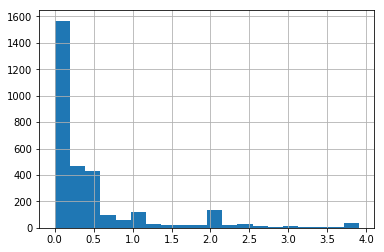

90th Percentile: 2
95th Percentile: 2
99th Percentile: 4


0.0001

In [23]:
fieldoi = 'Volumegen'
spoofevents[fieldoi].clip(0,spoofevents[fieldoi].quantile(0.99)).hist(bins=20); plt.show()
perc(0.9,spoofevents[fieldoi])
perc(0.95,spoofevents[fieldoi])
perc(0.99,spoofevents[fieldoi])
spoofevents[fieldoi].min()

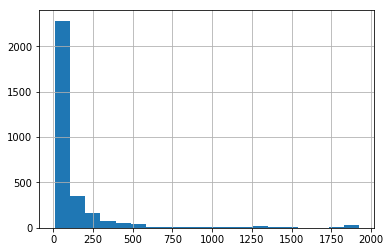

90th Percentile: 286
95th Percentile: 515
99th Percentile: 1923


10.002252

In [26]:
fieldoi = 'Genuine/spoofRatio'
spoofevents[fieldoi].clip(0,spoofevents[fieldoi].quantile(0.99)).hist(bins=20); plt.show()
perc(0.9,spoofevents[fieldoi])
perc(0.95,spoofevents[fieldoi])
perc(0.99,spoofevents[fieldoi])
spoofevents[fieldoi].min()

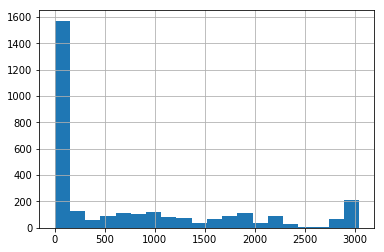

90th Percentile: 2290
95th Percentile: 3038
99th Percentile: 3674


0.0

In [24]:
fieldoi = 'Totalgain'
spoofevents[fieldoi].clip(0,spoofevents[fieldoi].quantile(0.95)).hist(bins=20); plt.show()
perc(0.9,spoofevents[fieldoi])
perc(0.95,spoofevents[fieldoi])
perc(0.99,spoofevents[fieldoi])
spoofevents[fieldoi].min()

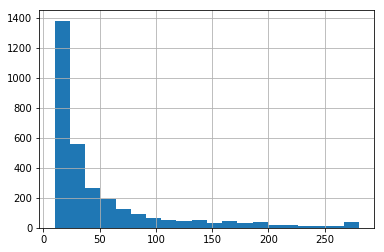

50th Percentile: 27
75th Percentile: 58
90th Percentile: 132
95th Percentile: 181
99th Percentile: 281


10

In [29]:
fieldoi = 'spoofOrderCount'
spoofevents[fieldoi].clip(0,spoofevents[fieldoi].quantile(0.99)).hist(bins=20); plt.show()
perc(0.50,spoofevents[fieldoi])
perc(0.75,spoofevents[fieldoi])
perc(0.9,spoofevents[fieldoi])
perc(0.95,spoofevents[fieldoi])
perc(0.99,spoofevents[fieldoi])
spoofevents[fieldoi].min()

In [12]:
events4032 = pd.DataFrame(events4032_eod.groupby(['Date','Security','Broker']).count().max(axis=1))
events4032.head(10)

,,,0
Date,Security,Broker,
2019-05-01,BTCUSD,22440,238
2019-05-02,ZECUSD,355845,11
2019-05-03,BTCUSD,31800,258
2019-05-04,BTCUSD,22440,5900
2019-05-05,BTCUSD,22440,1038
2019-05-07,BTCUSD,22440,1532
2019-05-08,BTCUSD,22440,5688
2019-05-09,BTCUSD,22440,93
2019-05-10,BTCUSD,22440,1393


#### >>> Testing

In [13]:
break

SyntaxError: 'break' outside loop (cell_name, line 4)

#### 4032.5 Account, Pair Aggregation

In [ ]:
# bool1 = alerts4032.groupby(['Broker','Security']).sum()[['gain_decimal','tradevalue']].rename(columns={'gain_decimal':'gain'})
# bool1['tradeval000'] = bool1['tradevalue']/1000
# countt = alerts4032.groupby(['Broker','Security']).count()['gain_decimal']

# round(pd.concat([countt,bool1.drop(columns='tradevalue')],axis=1).rename(columns={'gain_decimal':'count'}).reset_index())
# alerts4032.groupby(['Broker','Security']).count()

### Rollup Across All Scenarios (4022, 4023, 4032)

In [ ]:
renamedict = {'InstrumentName':'Security', 'AccountIDName':'Broker'}
fulltable = pd.concat([alerts4022,alerts4023],axis=0).rename(columns=renamedict).append(alerts4032,sort=True)
boolean = ~fulltable.isna().apply(any,axis=0)
boolean2 = boolean[boolean].index.tolist()
fulltable2 =  fulltable[boolean2 + ['LongText']]

In [ ]:
# for i in testdata['LongText']:
#     print(i,'\n')

### Case Level Analysis L&R

In [ ]:
alerting_1 = datetime.date(2019,3,1)
alerting_2 = datetime.date(2019,4,30)
acc = 22440

In [ ]:
testdata = fulltable2.loc[fulltable2['Broker'] == 605611]
testdata[['Account', 'numLayers', 'numStepsLast', 'bidShare', 'bidPrice', 'askShare', 'askPrice']] = testdata['LongText'].str.extract(r'\D+(\d+)\D+(\d+)\D+(\d+)\D+([\d.,]+)\D+([\d.,]+)\D+([\d.,]+)\D+([\d.,]+).+', expand=True).apply(pd.to_numeric)
testdata['diff'] = testdata['askShare']/testdata['bidPrice']

testdata['diff'] = round(testdata['askShare']/testdata['bidPrice'],4)
testdata[['bidShare','askShare']] = round(testdata[['bidShare','askShare']],2)

spoof_fig1 = testdata[['Date','Security','numLayers','numStepsLast','bidShare', 'bidPrice', 'askShare', 'askPrice','diff']]
spoof_fig1.set_index(['Security','Date'])

In [ ]:
spoof_fig1.shape

In [ ]:
query3 = """ 
        SELECT created::date, trading_pair, account_id, firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity) as val, sum(quantity) as units
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, created, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and trading_pair in ({p})) as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time
        
        group by firsttable.side, account_id, trading_pair, created::date;
        """.format(t1 = alerting_1.strftime("%Y-%m-%d"), t2 = alerting_2.strftime("%Y-%m-%d"), p = str(pd.unique(spoof_fig1['Security']).tolist()).replace('[','').replace(']',''))

test = execute_query_data_frame(query3,'engine')
table = pd.pivot_table(test, index=['trading_pair','account_id','created'], columns='side',values=['val','units']).fillna(0)
table2 = table['val'] / table['units']
table2['diff'] = table2['sell'] / table2['buy'] - 1

In [ ]:
for i in pd.unique(spoof_fig1['Security']).tolist():
    df = table2.reset_index().loc[table2.reset_index()['trading_pair'] == i, 'diff'].dropna()
    df.hist(bins=30)
    print(i,'99th percentile: ', df.quantile(0.99))
    plt.show()

In [ ]:
query = """
        SELECT *
        from account_derived_metadata
        where exchange_account_id in ({})
        """.format(acc)

test = execute_query_data_frame(query,'engine')
test.transpose()

In [ ]:
query = """
        SELECT side, trading_pair, sum(quantity)        
        from order_fill_event
        where account_id = {} and created::date between '{}' and '{}'
        group by side, trading_pair
        """.format(acc,alerting_1.strftime("%Y%m%d"),alerting_2.strftime("%Y%m%d"))

test_meta = execute_query_data_frame(query,'engine'); test_meta.head()
test_meta2 = pd.pivot_table(test_meta, index=['trading_pair'], columns='side',values='sum', aggfunc=np.sum)
round(pd.concat([test_meta2,pd.DataFrame(test_meta2.sum(axis=0)).rename(columns={0:'TOTAL'}).transpose()], axis=0),2)

In [ ]:
query3 = """ 
        SELECT account_id, trading_pair, firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity) as val, sum(quantity) as units
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and account_id in ({x})) as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time

        group by firsttable.trading_pair, firsttable.side, account_id;
        """.format(t1 = alerting_1.strftime("%Y%m%d"), t2 = alerting_2.strftime("%Y%m%d"), x=acc)

output3_D = execute_query_data_frame(query3,'engine'); output3_D
output3 = pd.pivot_table(output3_D, values=['val','units'], index=['trading_pair'], columns=['side'], aggfunc=np.sum); output3.astype(int)
pd.concat([output3,pd.DataFrame(output3.sum(axis=0)).rename(columns={0:'TOTAL'}).transpose()], axis=0).astype(int)

#### >>> Slide Show- Figure 1

In [ ]:
# alerts0_gb = alerts0.groupby(['AlertCode','ShortText'])
# fig1 = pd.concat([alerts0_gb['AccountIDName'].unique(), alerts0_gb.count()['AlertID']],axis=1).reset_index().rename(columns={'AlertID':'numEvents'})

# fig1['numAlerts'] = fig1['numEvents']
# fig1.loc[fig1['ShortText'] == 'MULTI ORDER SPOOFING EOD','numEvents'] = alerts4032.shape[0]
# fig1.loc[fig1['ShortText'] == 'MULTI ORDER SPOOFING','numEvents'] = 'NaN'
# fig1

In [ ]:
# summary = pd.pivot_table(alerts0.groupby(['AccountIDName','ShortText','AlertCode']).count(), values='Date', index=['AlertCode'], columns=['AccountIDName'], aggfunc=np.sum).fillna(value=0).astype(int)
# totalUP(summary)

#### >>> Slide Show- Figure 2

In [ ]:
# fulltable2.head()

In [ ]:
# events = pd.DataFrame(fulltable2.groupby([(fulltable2['Date'].dt.month),'AlertCode']).count()['Broker'])
# eventtable = pd.pivot_table(events, values='Broker', index=['Broker'], columns=['Date'], aggfunc=np.sum).fillna(value=0).astype(int)
# fig2 = totalUP(eventtable)
# fig2

#### >>> Slide Show- Figure 3

In [ ]:
# # Dates
# base = datetime.date(2019,3,1)
# datePD = pd.DataFrame(base + datetime.timedelta(days=x) for x in range(0, 59-1)).set_index(0)

# data = pd.DataFrame(fulltable2['Date'].value_counts()).rename(columns={'Date':'Events'})
# datedata = pd.concat([datePD,data['Events']],axis=1,sort=True).reset_index(drop=False)
# datedata['Date'] = pd.to_datetime(datedata['index'])
# datedata2 = datedata.fillna(value=0).drop(columns='index').sort_values('Date').reset_index(drop=True)
# datedata2.head()
# datedata2['Date'] = datedata2['Date'].astype(str)

In [ ]:
# # PLOT
# data = []
# for i in datedata2.values:
#     d = datetime.datetime.strptime(i[1], '%Y-%m-%d')
#     data.append([d,i[0]])
    
# data = numpy.array(data)

# fig, ax = plt.subplots(figsize=(15,4))
# locator = mpl.dates.WeekdayLocator()

# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y-%m-%d'))
# ax.grid(True)

# _=ax.plot_date(data[:,0], data[:,1],linestyle='-')
# for tick in ax.get_xticklabels():
#     tick.set_rotation(30)

#### >>> Slide Show- Figure 4

In [ ]:
# metrics(fulltable2['Broker'])

#### >>> Slide Show- Figure 5

In [ ]:
# metrics(fulltable2['Security'])

### Case Level Outputs

In [ ]:
# pd.pivot_table(fulltable2.groupby(['Broker','AlertCode']).count(), values='Security', index=['AlertCode'], columns=['Broker'], aggfunc=np.sum).fillna(0).astype(int)

In [ ]:
# pd.pivot_table(fulltable2.groupby(['Broker','AlertCode']).count(), values='Security', index=['AlertCode'], columns=['Broker'], aggfunc=np.sum).fillna(0).astype(int)

In [ ]:
# fulltable2.loc[fulltable2['Broker'] == 202474].groupby(['Security','Date']).count()

In [ ]:
# gpDate = fulltable2.groupby('Broker')

# gpDate2 = pd.concat([gpDate['Date'].count(),gpDate['AlertCode'].apply(pd.unique).apply(sorted),gpDate['Date'].min(),gpDate['Date'].max()],axis=1)
# gpDate2.columns = ['Count','Scenarios','Date_min', 'Date_max']
# gpDate2['diff'] = gpDate2['Date_max'] - gpDate2['Date_min']

In [ ]:
# casedict = {}
# for i in fulltable2['Broker'].value_counts().index.tolist(): casedict[i] = fulltable2.loc[fulltable2['Broker'] == i]

# casedict.keys()

# writerSPOOF = pd.ExcelWriter('SPOOFfigures.xlsx', engine='xlsxwriter')

# for i in casedict.keys():
#     casedict[i].to_excel(writerSPOOF, str(i))

# writerSPOOF.save()

In [ ]:
# case44_0 = pd.DataFrame(casedict[22440].groupby(['Security','AlertCode']).count()['Broker'])
# pd.pivot_table(case44_0, values='Broker', index=['AlertCode'], columns=['Security'], aggfunc=np.sum).fillna(0).astype(int)

# case45_0 = pd.DataFrame(casedict[202474].groupby(['Security','AlertCode']).count()['Broker'])
# pd.pivot_table(case45_0, values='Broker', index=['AlertCode'], columns=['Security'], aggfunc=np.sum).fillna(0).astype(int)

# case46_0 = pd.DataFrame(casedict[355845].groupby(['Security','AlertCode']).count()['Broker'])
# pd.pivot_table(case46_0, values='Broker', index=['AlertCode'], columns=['Security'], aggfunc=np.sum).fillna(0).astype(int)

### High Level Analytics

### Queries

In [ ]:
# query = """
#         SELECT *
#         from daily_conversion_rates 
#         where created between '2019-03-09' and '2019-03-12' and trading_pair = 'LTCUSD';
#         """

# test = execute_query_data_frame(query,'engine')
# test

#### Initialize Excel Writer

In [ ]:
# writer = pd.ExcelWriter('WashAlertReview_Figures.xlsx', engine='xlsxwriter')
# fig_0.to_excel(writer, 'fig_0')
# writer.save()

In [ ]:
thisacc = 22440

In [ ]:
newdf2 = newdf.loc[newdf['Broker'] == thisacc].fillna(0)
newdf2['VolumespoofSide'] = newdf2['VolumespoofSide'].str.replace(' ','').str.replace('x','').astype(float)
newdf2['PricespoofSide'] = newdf2['PricespoofSide'].str.replace(' ','').astype(float)

In [ ]:
spoofgb = newdf2.groupby(['Date','spoofEventNr'])

count = spoofgb['spoofOrderCount'].max().astype(int)
tradingpair = spoofgb['Security'].apply(pd.unique).apply(lambda col: col[0])
direction = spoofgb['Direction'].apply(lambda col: col.value_counts().index[1])
avgspoofvol = spoofgb['VolumespoofSide'].mean()
avgspoofp = spoofgb['PricespoofSide'].mean()
priceAfter = spoofgb['price'].sum()
priceBefore = spoofgb['pricebefore'].sum()
tradevol = spoofgb['vol'].max()

In [ ]:
spooftable = pd.concat([count, tradingpair, direction, avgspoofvol, round(avgspoofp,2), priceBefore, priceAfter, tradevol],axis=1)
spooftable.columns = ['count', 'tradingpair', 'direction', 'avgspoofvol', 'avgspoofp', 'priceBefore', 'priceAfter', 'tradevol']
spooftable.head()

In [ ]:
spoof_byside = spooftable.reset_index()
spoof_byside['neg'] = 2 * (spoof_byside['direction'] == 'buy')-1
spoof_byside['adv'] = spoof_byside['priceAfter']/spoof_byside['priceBefore']-1
spoof_byside[['count', 'avgspoofvol', 'avgspoofp', 'priceBefore', 'priceAfter']] = spoof_byside[['count', 'avgspoofvol', 'avgspoofp', 'priceBefore', 'priceAfter']].mul(spoof_byside['neg'],axis=0)
spoof_byside['ratio'] = spoof_byside['avgspoofvol'] / spoof_byside['tradevol']

spoof_byside.head()

In [ ]:
spoof_byside.sort_values('ratio',ascending =False)

In [ ]:
break

In [ ]:
spoof_byside.max()['Date'] - spoof_byside.min()['Date']

In [ ]:
spoof_byside['ratio'].hist(bins=100)
print('Ratio of Average Spoof Volume to Actual Traded Volume')

In [ ]:
spoof_byside['avgspoofvol'].hist(bins=100)

In [ ]:
spoofsperday = spoof_byside.groupby('Date').max()['spoofEventNr']
print('percentile 95: ',int(spoofsperday.quantile(0.95)))
print('percentile 99: ',int(spoofsperday.quantile(0.99)))

spoofsperday.hist(bins=100)
print('Number of Spoofing Alert Events per Day')

In [ ]:
eventsperspoof = spoof_byside['count']
eventsperspoof.hist(bins=100)
print('Number of Spoofs per Alert Event')

In [ ]:
spoof_byside['adv'].hist(bins=50)
print('Price Advantage Gained from Spoofing (Percentage)')

In [ ]:
alerting_1 = datetime.date(2019,3,1)
alerting_2 = datetime.date(2019,4,30)

query = """ 
        SELECT account_id, trading_pair, firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity) as val, sum(quantity) as units
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and account_id in ({x})) as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time

        group by firsttable.trading_pair, firsttable.side, account_id;
        """.format(t1 = alerting_1.strftime("%Y%m%d"), t2 = alerting_2.strftime("%Y%m%d"), x=thisacc)

data = execute_query_data_frame(query,'engine')
data1 = pd.pivot_table(data, values=['val','units'], index=['trading_pair'], columns=['side'], aggfunc=np.sum);
round(pd.concat([data1,data1['val']/data1['units']],axis=1).transpose()).astype(int)

In [ ]:
alerting_1 = datetime.date(2019,3,1)
alerting_2 = datetime.date(2019,4,30)

query = """ 
        SELECT account_id, trading_pair, firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity) as val, sum(quantity) as units
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and account_id in ({x}) and trading_pair = 'BTCUSD') as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time

        group by firsttable.trading_pair, firsttable.side, account_id;
        """.format(t1 = alerting_1.strftime("%Y%m%d"), t2 = alerting_2.strftime("%Y%m%d"), x=thisacc)

data = execute_query_data_frame(query,'engine')
data1 = pd.pivot_table(data, values=['val','units'], index=['trading_pair'], columns=['side'], aggfunc=np.sum); output3.astype(int)
round(pd.concat([data1,data1['val']/data1['units']],axis=1).transpose()).astype(int)

In [ ]:
query = """ 
        SELECT account_id, firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity)/1000000 as valmil
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and account_id in ({x}) and trading_pair = 'BTCUSD') as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time

        group by account_id, firsttable.side;
        """.format(t1 = alerting_1.strftime("%Y%m%d"), t2 = alerting_2.strftime("%Y%m%d"), x=thisacc)

data = execute_query_data_frame(query,'engine'); data
# data1 = pd.pivot_table(data, values=['val','units'], index=['trading_pair'], columns=['side'], aggfunc=np.sum); output3.astype(int)
# round(pd.concat([data1,data1['val']/data1['units']],axis=1).transpose(),2)

In [ ]:
query = """ 
        SELECT firsttable.side, sum(firsttable.price * COALESCE(secondtable.open_price,1) * quantity)/1000000 as valmil
        
        from  
            (SELECT account_id, event_id, side, price, quantity, trading_pair, date_trunc('minute', created) start_time, substring(trading_pair::varchar,4,6) as trunc
            from order_fill_event 
            where created::date between '{t1}' and '{t2}' and trading_pair = 'BTCUSD') as firsttable
        left join 
            (SELECT substring(trading_pair::varchar,1,3) as truncmatch, start_time, open_price
            from candles_1m 
            where start_time::date between '{t1}' and '{t2}' and substring(trading_pair::varchar,4,6) = 'USD') as secondtable
        
        on firsttable.trunc = secondtable.truncmatch and firsttable.start_time = secondtable.start_time

        group by firsttable.side;
        """.format(t1 = alerting_1.strftime("%Y%m%d"), t2 = alerting_2.strftime("%Y%m%d"), x=thisacc)

data = execute_query_data_frame(query,'engine'); data
# data1 = pd.pivot_table(data, values=['val','units'], index=['trading_pair'], columns=['side'], aggfunc=np.sum); output3.astype(int)
# round(pd.concat([data1,data1['val']/data1['units']],axis=1).transpose(),2)

In [ ]:
alerting_1 = datetime.date(2019,3,1)
alerting_2 = datetime.date(2019,4,30)

test = SmartsCsvDataModel(download_data=True).evaluate(instrument='BTCUSD', evaluation_date=alerting_2, begin_date=alerting_1, use_db=False)

In [ ]:
data = data0.loc[(data0['account_id'] == thisacc) & (data0['event_type'] != 'Initial')]
# data1 = pd.DataFrame(data.groupby(['order_id','event_date','event_type']).count()['event_id'])
# data2 = pd.pivot_table(data1, index=['order_id','event_date'], columns = 'event_type', values='event_id')
# data3 = data2.loc[~data2['Place'].isna()]

In [ ]:
# data4 = data3.groupby('event_date').sum(); data4

# data3['fillrate'] = 1 - data3['Cancel']/data3['Place']

In [ ]:
test3 = data0.loc[(data0['event_type'] != 'Initial') & (data0['account_id'] == thisacc)]

gb = test3.groupby('order_id')
test4 = pd.concat([gb['original_quantity'].min(),gb['remaining_quantity'].min(),gb['total_exec_quantity'].max()],axis=1)
test4['testquant'] = test4[['remaining_quantity','total_exec_quantity']].sum(axis=1)
test4.loc[test4['original_quantity'] != test4['testquant']]
test4['date'] = test4.index.map(test3.groupby(['order_id',test3['date_time'].dt.date]).count()['account_id'].reset_index().set_index('order_id')['date_time'].to_dict())
test5 = test4.groupby('date').sum()

test5['fillrate'] = test5['total_exec_quantity']/test5['original_quantity']
test5

In [ ]:
plt.rcParams['figure.figsize'] = (15,5)
plt.plot_date(x=test5.index, y=test5['fillrate'], fmt="go-",xdate=True)

plt.ylabel("Fill Rate")
plt.title("{} - {}: Daily Fill Rate (by Volume) - Account {}".format(alerting_1.strftime("%Y/%m/%d"),alerting_2.strftime("%Y/%m/%d"), thisacc))
plt.grid(True)
plt.legend()
plt.xticks(rotation=20)
plt.savefig("{}{}_PD_dailyfillRate.png".format(alerting_1.strftime("%Y%b"),alerting_2.strftime("%b")))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = (15,5)
plt.plot_date(x=test5.index, y=test5['total_exec_quantity'], fmt="go-",xdate=True)

plt.ylabel("Fill Rate")
plt.title("{} - {}: Total Executed Volume - Account {}".format(alerting_1.strftime("%Y/%m/%d"),alerting_2.strftime("%Y/%m/%d"), thisacc))
plt.grid(True)
plt.legend()
plt.xticks(rotation=20)
plt.savefig("{}{}_PD_dailyfillRate.png".format(alerting_1.strftime("%Y%b"),alerting_2.strftime("%b")))
plt.show()

In [ ]:
output4 = pd.concat([data1,pd.DataFrame(data1.sum(axis=0)).rename(columns={0:'TOTAL'}).transpose()], axis=0).astype(int)

In [ ]:
query = """
        SELECT *
        from account_derived_metadata
        where exchange_account_id in ({})
        """.format(thisacc)

test = execute_query_data_frame(query,'engine')
test.transpose()